# Visualize the video

In [12]:
import numpy as np

In [1]:
# Display the reconstruction video
def show_local_mp4_video(file_name, width=640, height=480):
  import io
  import base64
  from IPython.display import HTML
  video_encoded = base64.b64encode(io.open(file_name, 'rb').read())
  return HTML(data='''<video width="{0}" height="{1}" alt="test" controls>
                      <source src="data:video/mp4;base64,{2}" type="video/mp4" />
                      </video>'''.format(width, height, video_encoded.decode('ascii')))

!ffmpeg -y -hide_banner -loglevel error -i PHALP_vid.mp4 PHALP_vid_ffmpg.mp4
show_local_mp4_video('PHALP_vid_ffmpg.mp4', width=960, height=540)

In [3]:
from IPython.display import Video

#Video("vid.mp4")


In [2]:
import joblib
results = joblib.load("demo_vid.pkl")

In [25]:
def angle_between_vectors(v1, v2):
    # Calculate the dot product of the two vectors
    dot_product = np.dot(v1, v2)

    # Calculate the magnitude (norm) of each vector
    norm1 = np.linalg.norm(v1)
    norm2 = np.linalg.norm(v2)

    # Calculate the cosine of the angle
    cos_angle = dot_product / (norm1 * norm2)

    # Make sure the value is within the valid range for arccos
    # This handles potential floating point errors that might occur
    cos_angle = np.clip(cos_angle, -1, 1)

    # Calculate the angle in radians
    angle_radians = np.arccos(cos_angle)

    return angle_radians

def rad2deg(rad):
    deg=[]
    for i in range(len(rad)):
        deg.append(rad[i]*180/np.pi)
    return deg

In [15]:
import numpy as np

number_of_frames = len(results)


l2_distances = np.zeros(number_of_frames)  # Array to hold L2 distance for each frame
left_ankles = np.zeros((number_of_frames, 2))   # Array to hold left ankle 2D coordinates for each frame
right_ankles = np.zeros((number_of_frames, 2))  # Array to hold right ankle 2D coordinates for each frame

total_joints = np.zeros((number_of_frames,90)) 
boundary_boxes = np.zeros((number_of_frames, 4)) 
center_mass = np.zeros((number_of_frames, 3))

left_knee_angle = np.zeros(number_of_frames)
right_knee_angle = np.zeros(number_of_frames)

for frame_number, frame_key in enumerate(sorted(results.keys())):
    frame_data = results[frame_key]
    #print(frame_data['bbox'][0])
    #print(frame_data["tid"])

    

    # Add boundary box data from each frame
    boundary_boxes[frame_number] = frame_data['tracked_bbox'][0]
    #print(len(frame_data['tracked_bbox']) )

    # Assuming '3d_joints' provides the 3D joint locations
    left_ankle_3d = np.array(frame_data['3d_joints'][0][7])
    right_ankle_3d = np.array(frame_data['3d_joints'][0][8])

    # Calculate L2 distance using the 3D coordinates
    l2_distance = np.linalg.norm(right_ankle_3d - left_ankle_3d)

    l2_distances[frame_number] = l2_distance

    # Assuming '2d_joints' provides the 2D projections of the 3D joints
    # Extracting the 2D coordinates for the left and right ankles
    tempx = frame_data['2d_joints'][0][::2]
    tempy = frame_data['2d_joints'][0][1::2]

    left_ankle_2d = [tempx[14],tempy[14]]
    right_ankle_2d = [tempx[11],tempy[11]]

    total_joints[frame_number] = frame_data['2d_joints'][0]

    center_mass[frame_number] =  frame_data['3d_joints'][0][0]

    #print(right_ankle_2d)

    # Assuming '3d_joints' provides the 3D joint locations
    left_hip_3d = np.array(frame_data['3d_joints'][0][9])
    left_knee_3d = np.array(frame_data['3d_joints'][0][10])
    left_ankle_3d = np.array(frame_data['3d_joints'][0][11])
    left_toe_3d = np.array(frame_data['3d_joints'][0][22])

    right_hip_3d = np.array(frame_data['3d_joints'][0][12])
    right_knee_3d = np.array(frame_data['3d_joints'][0][13])
    right_ankle_3d = np.array(frame_data['3d_joints'][0][14])
    right_toe_3d = np.array(frame_data['3d_joints'][0][19])


    left_thigh_vector = left_knee_3d - left_hip_3d
    left_calf_vector = left_ankle_3d - left_knee_3d
    left_foot_vector = left_toe_3d - left_ankle_3d

    right_thigh_vector = right_knee_3d - right_hip_3d
    right_calf_vector = right_ankle_3d - right_knee_3d
    right_foot_vector = right_toe_3d - right_ankle_3d

    left_knee_angle[frame_number] = np.pi/2.0 - angle_between_vectors(left_thigh_vector,left_calf_vector)
    right_knee_angle[frame_number] = np.pi/2.0 - angle_between_vectors(right_thigh_vector,right_calf_vector)


    # Add the 2D coordinates to the arrays
    left_ankles[frame_number] = left_ankle_2d
    right_ankles[frame_number] = right_ankle_2d

[ 7 43]
0.3493480980396271 2 0.04 1.2 0.4192177176475525 1.509183783531189


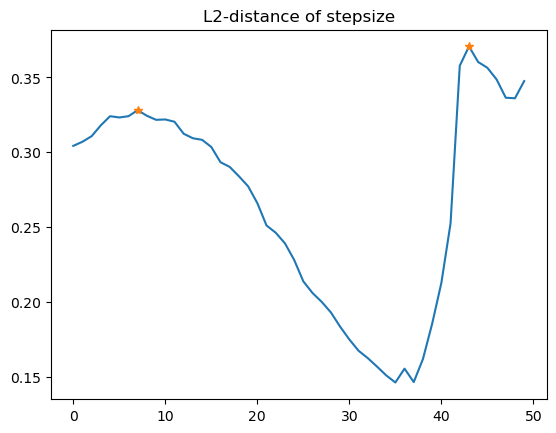

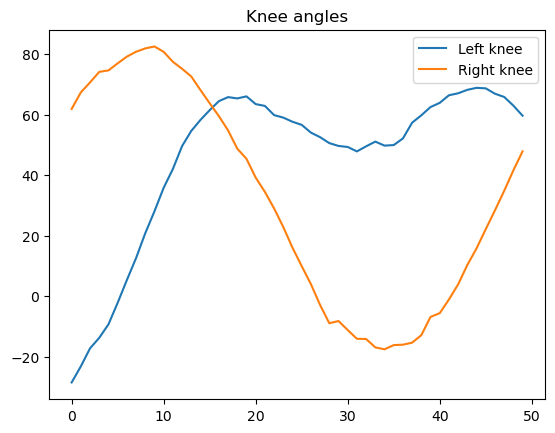

In [28]:
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
import cv2
# Open the video
cap = cv2.VideoCapture('PHALP_vid.mp4')
fps = cap.get(cv2.CAP_PROP_FPS)
totalNoFrames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
durationInSeconds = totalNoFrames // fps
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
cap.release()

local_maxima_indices = argrelextrema(l2_distances,np.greater,order=10)[0]
local_maxima_values = l2_distances[local_maxima_indices]
print(local_maxima_indices)

mean_stride = np.mean(local_maxima_values)

total_number_of_steps = len(local_maxima_indices)

average_steps_per_frame = total_number_of_steps / totalNoFrames

average_steps_per_second = average_steps_per_frame * fps

distance_per_second = average_steps_per_second * mean_stride
km_hour = distance_per_second * 3.6
print(mean_stride, total_number_of_steps, average_steps_per_frame, average_steps_per_second,distance_per_second, km_hour)

plt.title("L2-distance of stepsize")
plt.plot(l2_distances)
plt.plot(local_maxima_indices,local_maxima_values,"*")
plt.show()

plt.title("Knee angles")
plt.plot(rad2deg(left_knee_angle))
plt.plot(rad2deg(right_knee_angle))
plt.legend(["Left knee", "Right knee"])
plt.show()



In [29]:
def calculateSpeed(fps,frame_arr):
    # Open the video
    totalNoFrames = len(frame_arr)

    durationInSeconds = totalNoFrames / fps

    distance = np.linalg.norm(center_mass[frame_arr[0]] - center_mass[frame_arr[-1]])

    distance_per_second = distance/durationInSeconds

    #km_hour = distance_per_second * 3.6

    return distance_per_second

    

In [32]:
import cv2

# Open the video
cap = cv2.VideoCapture('PHALP_vid.mp4')
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
step_count = 0
# If you need to convert an entire list of normalized coordinates:
left_ankles_pixels = left_ankles * np.array([width, height])
right_ankles_pixels = right_ankles * np.array([width, height])
#print(right_ankles_pixels)

#convert radians to degrees
left_knee_angle_deg=rad2deg(left_knee_angle)
right_knee_angle_deg=rad2deg(right_knee_angle)

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('PHALP_vid_l2.mp4', fourcc, fps, (width, height))

frame_number = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    if frame_number < len(l2_distances):
        # Display boundary box
        scale = 1440/1920 # Get scaling factor through dividing new by old dimensions of video
        x,y,w,h = boundary_boxes[frame_number] * scale
        start_point = (int(x),int(y))
        end_point = (int((x+w)) ,int((y+ h)))
        #print(end_point)
        cv2.rectangle(frame, start_point, end_point, (255, 0, 0), 2)

        # Display the L2 distance
        l2_distance = l2_distances[frame_number]
        text = f"L2 distance: {l2_distance:.2f}"
        text_size = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)[0]
        text_x =  int(x + w/2 - text_size[0]/2)
        text_y = int(y - 15*1)
        cv2.putText(frame, text, (text_x,text_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

        # Display steps taken
        if (frame_number in local_maxima_indices):
            step_count += 1
        
        text = f"Steps taken: {int(step_count)}"
        text_size = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)[0]
        text_x =  int(x + w/2 - text_size[0]/2)
        text_y = int(y - 15*2)
        cv2.putText(frame, text, (text_x,text_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

        # Draw a line between the left and right ankles
        x_coords = total_joints[frame_number][::2] 
        y_coords = total_joints[frame_number][1::2]
        #print(frame_number)

        x_min = min(x_coords)
        x_max = max(x_coords)
        x_delta = x_max - x_min
        #print(x_delta)

        y_min = min(y_coords)
        y_max = max(y_coords)
        y_delta = y_max - y_min

        x_scale = w/x_delta
        y_scale = h/y_delta

        #plt.scatter(x_coords[11] * (x_scale)+(x - x_min*x_scale), y_coords[11] * (y_scale)+(y- y_min*y_scale),s=5, c= "red")
        #print(left_ankles_pixels[frame_number][0]*(x_scale)+(x - x_min*x_scale))

        #left_ankle = tuple(map(int, left_ankles_pixels[frame_number]))
        #right_ankle = tuple(map(int, right_ankles_pixels[frame_number]))
        left_ankle = (int(left_ankles_pixels[frame_number][0] * (x_scale)+(x - x_min*x_scale)),int( left_ankles_pixels[frame_number][1] * (y_scale)+(y- y_min*y_scale)))
        right_ankle = (int(right_ankles_pixels[frame_number][0] * (x_scale)+(x - x_min*x_scale)),int( right_ankles_pixels[frame_number][1] * (y_scale)+(y- y_min*y_scale)))
        #print(left_ankle)
        cv2.line(frame, left_ankle, right_ankle, (255, 0, 0), 2)


        # Display Speed
        if (1 < frame_number < totalNoFrames-2):
            speed = calculateSpeed(fps, [frame_number-1,frame_number,frame_number+1])
            text = f" m / s: {speed:.2f}"
            text_size = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)[0]
            text_x =  int(x + w/2 - text_size[0]/2)
            text_y = int(y - 15*3)
            cv2.putText(frame, text, (text_x,text_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
        
        # Display knee angles
        left_knee = left_knee_angle_deg[frame_number]
        right_knee = right_knee_angle_deg[frame_number]
        text = f"Left knee: {left_knee:.2f} Right knee: {right_knee:.2f}"
        text_size = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)[0]
        text_x =  int(x + w/2 - text_size[0]/2)
        text_y = int(y - 15*4)
        cv2.putText(frame, text, (text_x,text_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)



        # Display idx of boundary box


    out.write(frame)
    frame_number += 1

# Release everything when job is finished
cap.release()
out.release()


In [33]:
!ffmpeg -y -hide_banner -loglevel error -i PHALP_vid_l2.mp4 PHALP_vid_l2_ffmpg.mp4
show_local_mp4_video('PHALP_vid_l2_ffmpg.mp4', width=960, height=540)